In [1]:
from IPython.display import clear_output

import torch
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models import ConvNet
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_noniid, CustomSubset


N_CLIENTS = 10
DIRICHLET_ALPHA = 1.0

In [2]:
# data preparing

data = datasets.EMNIST(root=".", split="byclass", download=True, transform=transforms.Compose([transforms.ToTensor()]))

mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

idcs = np.random.permutation(len(data))
train_idcs, test_idcs = idcs[:10000], idcs[10000:20000]
train_labels = data.train_labels.numpy()

client_idcs = split_noniid(
    train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS
)

client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
test_data = CustomSubset(data, test_idcs)

for i, client_datum in enumerate(client_data):
    if i < 5:
        client_datum.subset_transform = transforms.Compose(
            [transforms.RandomRotation((180, 180))]
        )

d:\anaconda3\envs\fedavg\Lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


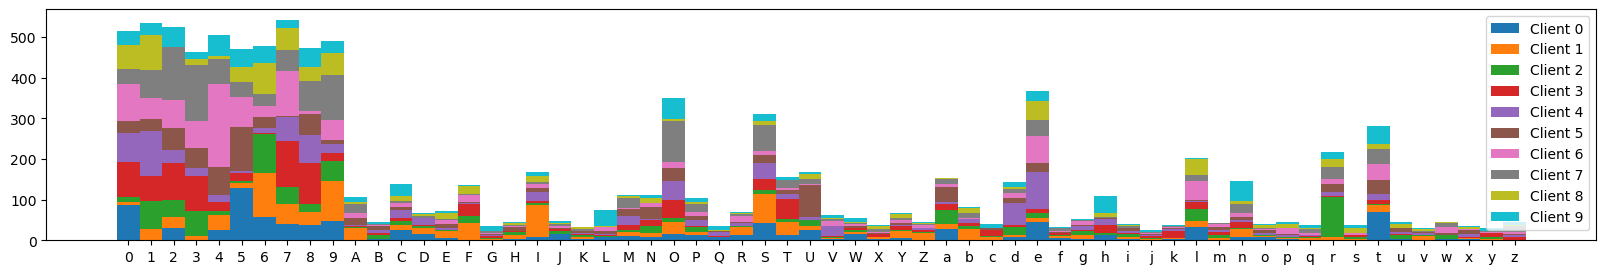

In [3]:
plt.figure(figsize=(20,3))
plt.hist([train_labels[idc]for idc in client_idcs], stacked=True, 
         bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1),
        label=["Client {}".format(i) for i in range(N_CLIENTS)])
plt.xticks(np.arange(62), mapp)
plt.legend()
plt.show()

In [4]:
# declare clients and server

clients = [
    Client(ConvNet, lambda x: torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, idnum=i)
    for i, dat in enumerate(client_data)
]
server = Server(ConvNet, test_data)

Client 0:


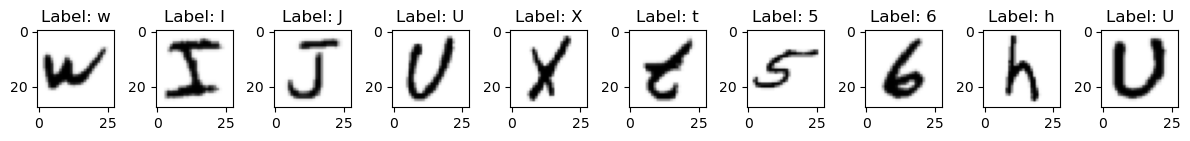

Client 5:


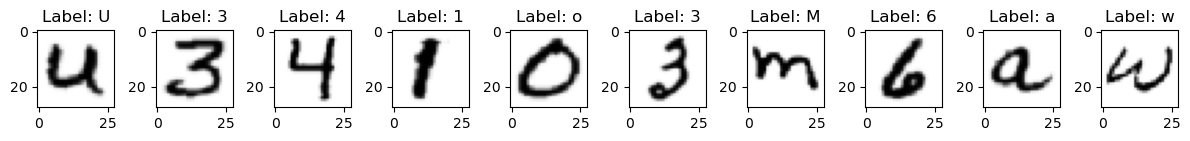

In [5]:
for client in [clients[0], clients[5]]:
    x, y = iter(client.train_loader)._next_data()

    print("Client {}:".format(client.id))
    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i,0].numpy().T, cmap="Greys")
        plt.title("Label: {}".format(mapp[y[i].item()]))
    plt.show()

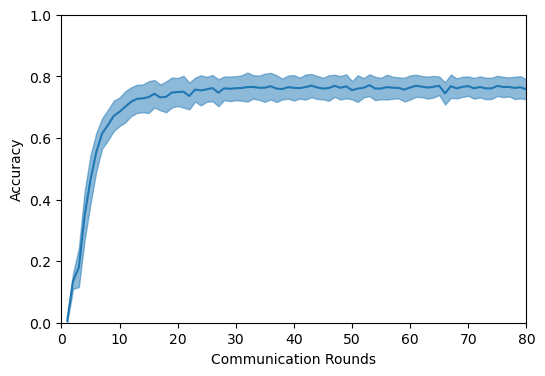

In [6]:
# training process

COMMUNICATION_ROUNDS = 80

fl_stats = ExperimentLogger()

client_indices = [np.arange(len(clients)).astype("int")]

for c_round in range(1, COMMUNICATION_ROUNDS + 1):

    for client in clients:
        client.synchronize_with_server(server)

    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=1)
        client.reset()

    server.aggregate_weight_updates(clients)

    acc_clients = [client.evaluate() for client in clients]

    fl_stats.log(
        {
            "acc_clients": acc_clients,
            "rounds": c_round,
        }
    )

    display_train_stats(fl_stats, COMMUNICATION_ROUNDS)

In [7]:
# results

for idc in client_indices:
    server.cache_model(idc, clients[idc[0]].W, acc_clients)

results = np.zeros([10, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

In [8]:
frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) 
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9
FL Model,0.740933,0.772947,0.790698,0.739130,0.709184,0.767568,0.804167,0.800000,0.727848,0.722222
